直交周波数分割変調のシミュレーション
===

<img src='./imgsrc/OFDMA変調.drawio.png'>

In [2]:
# import
import numpy as np
import sys
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True, floatmode="maxprec_equal")
plt.rcParams['figure.figsize'] = (12,4)

In [3]:
Nsc = 32
N_GI = 8
Lpilot = 2
NofdmSymbol = 500
Ndata = Nsc * NofdmSymbol
SNRdB = 20
Delay = np.array([[0,8]])
Npath = max(Delay.shape)

In [4]:
def rndCode(codeSize, Type):
    """
    codeSize: 生成するランダム系列の大きさ（行数ｘ列数）を指定
    Type: タイプ指定 0: [0,1], 1: [-1, 1]
    """
    
    rndCode = np.random.randn(*codeSize)
    
    if rndCode.ndim > 2:
        sys.exit()
    
    dataSize = rndCode.shape
    if len(dataSize) == 1:
        sys.exit()
    
    if Type == 0:
        rndCode = np.where(rndCode <= 0, 0, 1)
    else:
        rndCode = np.where(rndCode <= 0, -1, 1)
    
    return rndCode

In [5]:
# BPSK変調器
def bpskMod(data):
    bpskSymbol = data.copy()
    np.place(bpskSymbol, bpskSymbol == 0, -1)
    
    return bpskSymbol

In [6]:
# 送信機
data = rndCode([Ndata,1], 0)
bpskSymbol = bpskMod(data)
Nsymbol = max(bpskSymbol.shape)
spOut = bpskSymbol.reshape(Nsc,NofdmSymbol, order='F').copy()

pilotMat = np.ones((Nsc,Lpilot))
ofdmSymbol = np.hstack([pilotMat,spOut])
ofdmSymbol_pilot = np.fft.ifft(ofdmSymbol, axis=0)
gi = ofdmSymbol_pilot[-1-N_GI:-1,:]
ofdmSymbol_pilot_GI = np.vstack([gi,ofdmSymbol_pilot])
sOFDM = np.array([ofdmSymbol_pilot_GI.flatten('F')]).T;
ofdmSymbolMat = sOFDM @ np.ones((1, Npath))

In [7]:
# 送信データ
data.T

array([[0, 1, 1, ..., 0, 1, 1]])

In [8]:
# 遅延発生器
def delayGen(delayVec, ssSigMat):
    sigMat = ssSigMat.copy()
    Nsig = delayVec.shape[1]
    
    if Nsig != sigMat.shape[1]:
        sys.exit(1)
    
    for co in range(0, Nsig):
        if delayVec[0,co] > 0:
            roll_num = delayVec[0][co]
            sigMat[:,co] = np.roll(sigMat[:,co],roll_num)
            sigMat[:roll_num, co] = 0
            
    return sigMat

In [9]:
def awgn(Pn, rn, cn):
    """
    Pn: 雑音電力
    ｒｎ: 行数
    cn: 列数
    """
    n = np.random.randn(rn, cn) + 1j*np.random.randn(rn, cn)
    n = n * np.sqrt(Pn/2)
    
    return n

In [10]:
# 伝送
ofdmSymbolMatDelayed = delayGen(Delay, ofdmSymbolMat)
chOut = ofdmSymbolMatDelayed @ np.ones((Npath,1))
Pn = 10**(-SNRdB/10) / Nsc
rSig = chOut + awgn(Pn, max(chOut.shape), 1)

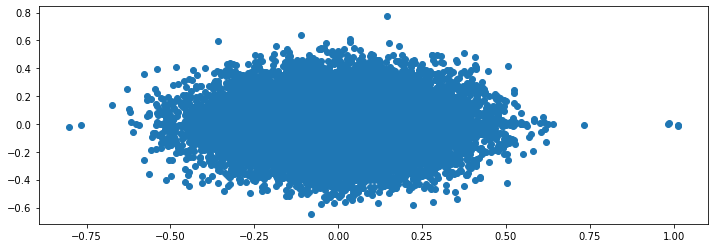

In [11]:
plt.scatter(rSig.real, rSig.imag)

In [12]:
# 受信機

spOutR = rSig.reshape((Nsc+N_GI), (Lpilot+NofdmSymbol),order='F').copy()
spOutR = spOutR[N_GI:, :]
fftOut = np.fft.fft(spOutR, axis=0) #**
pilotMatRx = fftOut[:,:Lpilot]
ofdmSymbolRx = fftOut[:,Lpilot:]

In [13]:
chCoeff = np.array([np.mean(pilotMatRx, axis=1)]).T
phaseShift = chCoeff/abs(chCoeff) * np.ones((1, NofdmSymbol))

In [14]:
ofdmSymbolRxCompensted = ofdmSymbolRx * phaseShift.conj()
ofdmSymbolRxCompensted = np.array([ofdmSymbolRxCompensted.flatten('F')]).T

In [15]:
# BPSK復調器
def bpskDem(rSig):
    """
    rSig : 受信信号
    rData:　受信データ
    """
    rData = np.ones(rSig.shape)
    rData[rSig < 0] =  0
    
    return rData

In [16]:
rData = bpskDem(ofdmSymbolRxCompensted)

In [17]:
#　受信データ
rData.T

array([[0., 1., 1., ..., 0., 0., 1.]])

In [18]:
# BER比較器
def ber(data1, data2):
    BER = np.sum(np.abs(data1-data2))/data1.size
    return BER

In [19]:
ber(data,rData)

0.119875

In [20]:
data

array([[0],
       [1],
       [1],
       ...,
       [0],
       [1],
       [1]])